# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

### Import the packages

In [1]:
# %%capture
# !apt install python-opengl
# !apt install ffmpeg
# !apt install xvfb
# !pip install pyvirtualdisplay
# !pip install pyglet==1.5.1
# !pip install gym_pygame

In [2]:
import numpy as np

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

import imageio
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gymnasium as gym

import wandb
from wandb.integration.sb3 import WandbCallback
import copy
import random
import cv2

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.vec_env import VecTransposeImage, DummyVecEnv, VecFrameStack, VecNormalize, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack


from src.cartpole import (
    Policy, ValueNetwork, 
    ReinforceTrainer, ReinforceWithBaselineTrainer,
    evaluate_agent, record_video,
    get_cartpole_hyperparameters, get_device
)

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation.

### The CartPole environment

In [3]:
# # Virtual display
# from pyvirtualdisplay import Display
# from IPython.display import Video, display

# virtual_display = Display(visible=0, size=(1400, 900))
# virtual_display.start()

In [4]:
env_id = "CartPole-v1"

env = gym.make(env_id)

eval_env = gym.make(env_id)

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

In [5]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  4
Sample observation [-3.5317602  -1.0644522   0.07358498 -1.1697373 ]


In [6]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

The Action Space is:  2
Action Space Sample 0


### Reinforce Architecture

> ⚠️ **Disclaimer**  
> L'implementazione riportata di seguito si basa su una combinazione di risorse pubblicamente disponibili e suggerite dal corso **Deep Reinforcement Learning with Hugging Face**. In particolare, il codice e i concetti sono stati ispirati e adattati da:
>
> - [Esempio ufficiale PyTorch REINFORCE](https://github.com/pytorch/examples/blob/main/reinforcement_learning/reinforce.py)  
> - [Implementazione REINFORCE di Udacity](https://github.com/udacity/deep-reinforcement-learning/blob/master/reinforce/REINFORCE.ipynb)  
> - [Pull Request di ottimizzazione di Chris1nexus](https://github.com/huggingface/deep-rl-class/pull/95)
>
> In particolare, l'efficiente calcolo del **reward-to-go** è stato adattato dal lavoro di [Chris1nexus](https://github.com/Chris1nexus), il cui codice e spiegazioni sono ben documentati nella [pull request](https://github.com/huggingface/deep-rl-class/pull/95) al corso Hugging Face.
>
> Queste fonti sono state selezionate tra quelle raccomandate nel modulo dedicato alla policy gradient del corso, e hanno fornito una base solida sia dal punto di vista teorico che implementativo.

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/reinforce.png" alt="Reinforce"/>


In [7]:
# Le classi Policy e ValueNetwork sono ora importate dal modulo src.cartpole.models
# Visualizziamo la definizione per riferimento:

print("Policy class è ora definita in src/cartpole/models.py")
print("ValueNetwork class è ora definita in src/cartpole/models.py")

Policy class è ora definita in src/cartpole/models.py
ValueNetwork class è ora definita in src/cartpole/models.py


### Reinforce Training

In [8]:
# La classe ReinforceTrainer è ora definita in src/cartpole/trainers.py
# Visualizziamo un messaggio per riferimento:

print("ReinforceTrainer class è ora definita in src/cartpole/trainers.py")
print("Contiene tutti i metodi: __init__, compute_returns, reinforce, plot_rewards")

ReinforceTrainer class è ora definita in src/cartpole/trainers.py
Contiene tutti i metodi: __init__, compute_returns, reinforce, plot_rewards


In [9]:
# La funzione evaluate_agent è ora definita in src/cartpole/utils.py
print("evaluate_agent function è ora definita in src/cartpole/utils.py")

evaluate_agent function è ora definita in src/cartpole/utils.py


In [10]:
# La funzione record_video è ora definita in src/cartpole/utils.py
print("record_video function è ora definita in src/cartpole/utils.py")

record_video function è ora definita in src/cartpole/utils.py


In [11]:
# Gli iperparametri sono ora definiti in src/cartpole/config.py
cartpole_hyperparameters = get_cartpole_hyperparameters()
print("Iperparametri CartPole:", cartpole_hyperparameters)

Iperparametri CartPole: {'h_size': 16, 'n_training_episodes': 600, 'n_evaluation_episodes': 10, 'max_t': 1000, 'gamma': 1.0, 'lr': 0.01, 'env_id': 'CartPole-v1', 'print_every': 10, 'save_path': 'best_reinforce.pt'}


In [12]:
device = get_device()
print(f"Device utilizzato: {device}")

Device utilizzato: cuda:0


Episode 10	Average Score: 26.50
Episode 20	Average Score: 30.40
Episode 20	Average Score: 30.40
Episode 30	Average Score: 30.27
Episode 30	Average Score: 30.27
Episode 40	Average Score: 35.75
Episode 40	Average Score: 35.75
Episode 50	Average Score: 40.58
Episode 50	Average Score: 40.58
Episode 60	Average Score: 45.38
Episode 60	Average Score: 45.38
Episode 70	Average Score: 53.24
Episode 70	Average Score: 53.24
Episode 80	Average Score: 57.83
Episode 80	Average Score: 57.83
Episode 90	Average Score: 68.92
Episode 90	Average Score: 68.92
Episode 100	Average Score: 85.73
Episode 100	Average Score: 85.73
Episode 110	Average Score: 118.02
Episode 110	Average Score: 118.02
Episode 120	Average Score: 146.24
Episode 120	Average Score: 146.24
Episode 130	Average Score: 182.39
Episode 130	Average Score: 182.39
Episode 140	Average Score: 217.68
Episode 140	Average Score: 217.68
Episode 150	Average Score: 260.93
Episode 150	Average Score: 260.93
Episode 160	Average Score: 303.27
Episode 160	Aver

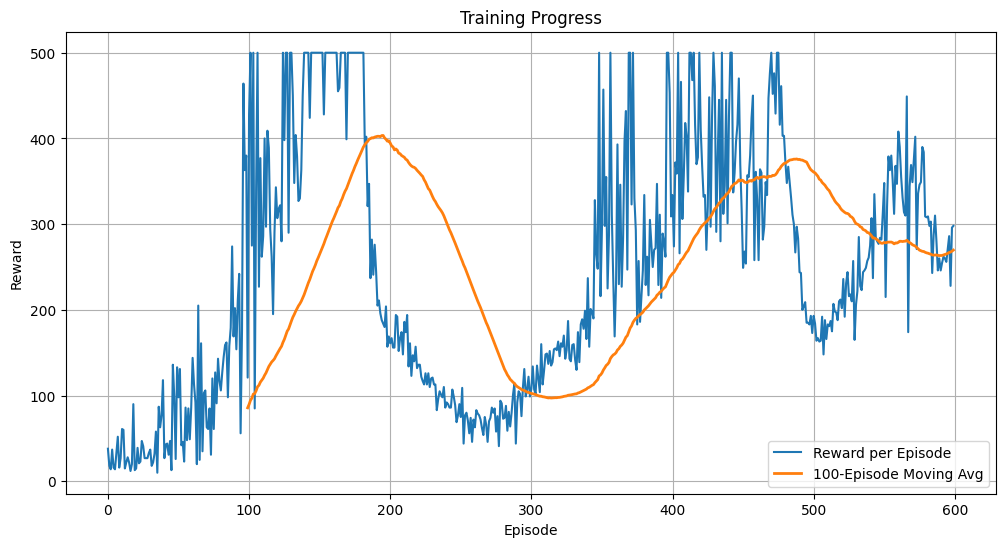

In [13]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Crea policy utilizzando le dimensioni dell'environment
policy = Policy(state_dim, action_dim, cartpole_hyperparameters["h_size"]).to(device)
optimizer = optim.Adam(policy.parameters(), lr=cartpole_hyperparameters["lr"])

# Crea trainer con device
trainer = ReinforceTrainer(
    policy, optimizer, env, 
    gamma=cartpole_hyperparameters["gamma"], 
    max_t=cartpole_hyperparameters['max_t'],
    device=device
)

# Esegui training
scores = trainer.reinforce(
    cartpole_hyperparameters['n_training_episodes'], 
    print_every=cartpole_hyperparameters["print_every"]
)

In [15]:
policy.to(device)
record_video(env, policy, "record/Cart_Pole.mp4")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video salvato in record/Cart_Pole.mp4


-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)


In questa variante dell’algoritmo REINFORCE, invece di aggiornare la policy solo in base al ritorno totale \( G_t \), si introduce una **baseline** per ridurre la varianza della stima del gradiente. Una scelta comune è usare una **value function** \( V(s_t) \), appresa tramite regressione sui ritorni osservati.

L’aggiornamento della policy diventa:

\[
\theta \leftarrow \theta + \alpha \, (G_t - V(s_t)) \, \nabla_\theta \log \pi(a_t | s_t)
\]

Dove:
- \( G_t \) è il ritorno cumulato dall’istante \( t \)
- \( V(s_t) \) è il valore stimato dello stato corrente
- \( A_t = G_t - V(s_t) \) è il **vantaggio**: quanto il risultato effettivo è migliore del previsto

In pratica:
- Addestriamo una seconda rete (`value_net`) per approssimare \( V(s) \)
- Usiamo \( A_t \) come pesatura per il gradiente della policy (invece di usare direttamente \( G_t \))
- Questo riduce la varianza dell’aggiornamento, stabilizzando il training

**Nota:** La rete del valore viene ottimizzata separatamente minimizzando l’errore quadratico tra \( V(s_t) \) e \( G_t \).




In [ ]:
# La classe ValueNetwork è ora definita in src/cartpole/models.py
print("ValueNetwork class è ora definita in src/cartpole/models.py")

In [ ]:
# La classe ReinforceWithBaselineTrainer è ora definita in src/cartpole/trainers.py
print("ReinforceWithBaselineTrainer class è ora definita in src/cartpole/trainers.py")

**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

Training REINFORCE senza baseline...
Episode 10	Average Score: 22.60
Episode 10	Average Score: 22.60
Episode 20	Average Score: 23.05
Episode 20	Average Score: 23.05
Episode 30	Average Score: 23.37
Episode 30	Average Score: 23.37
Episode 40	Average Score: 25.68
Episode 40	Average Score: 25.68
Episode 50	Average Score: 28.82
Episode 50	Average Score: 28.82
Episode 60	Average Score: 31.77
Episode 60	Average Score: 31.77
Episode 70	Average Score: 36.01
Episode 70	Average Score: 36.01
Episode 80	Average Score: 37.54
Episode 80	Average Score: 37.54
Episode 90	Average Score: 41.24
Episode 90	Average Score: 41.24
Episode 100	Average Score: 48.05
Episode 100	Average Score: 48.05
Episode 110	Average Score: 58.98
Episode 110	Average Score: 58.98
Episode 120	Average Score: 77.43
Episode 120	Average Score: 77.43
Episode 130	Average Score: 103.23
Episode 130	Average Score: 103.23
Episode 140	Average Score: 123.45
Episode 140	Average Score: 123.45
Episode 150	Average Score: 141.35
Episode 150	Average

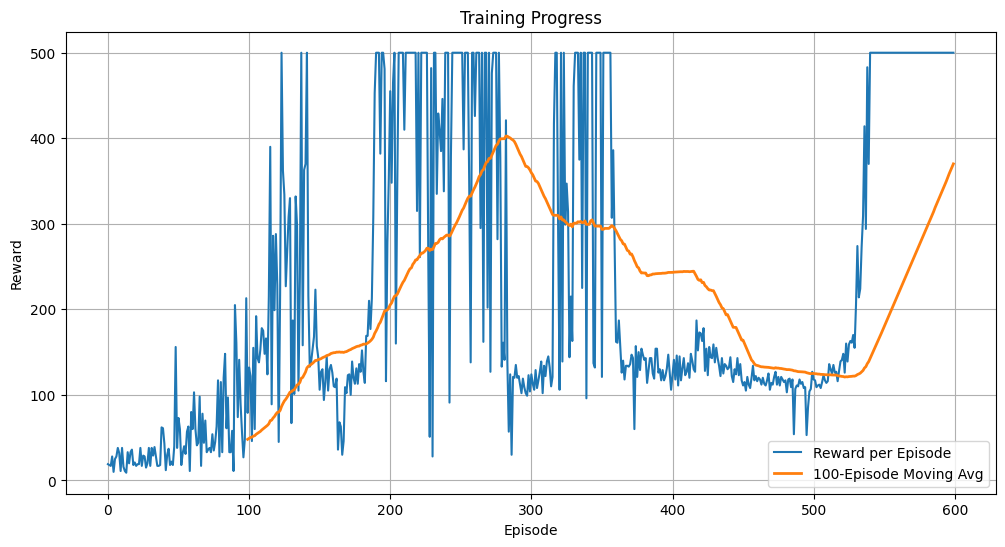


Training REINFORCE con baseline...


/home/vcivale/prova/Esercitazione_2/src/cartpole/trainers.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(R).to(self.device)))


Episode 10	Average Score: 23.20
Episode 20	Average Score: 26.15
Episode 20	Average Score: 26.15
Episode 30	Average Score: 30.33
Episode 30	Average Score: 30.33
Episode 40	Average Score: 35.10
Episode 40	Average Score: 35.10
Episode 50	Average Score: 38.54
Episode 50	Average Score: 38.54
Episode 60	Average Score: 40.03
Episode 60	Average Score: 40.03
Episode 70	Average Score: 40.99
Episode 70	Average Score: 40.99
Episode 80	Average Score: 46.56
Episode 80	Average Score: 46.56
Episode 90	Average Score: 53.11
Episode 90	Average Score: 53.11
Episode 100	Average Score: 61.62
Episode 100	Average Score: 61.62
Episode 110	Average Score: 74.83
Episode 110	Average Score: 74.83
Episode 120	Average Score: 86.58
Episode 120	Average Score: 86.58
Episode 130	Average Score: 95.97
Episode 130	Average Score: 95.97
Episode 140	Average Score: 108.22
Episode 140	Average Score: 108.22
Episode 150	Average Score: 127.90
Episode 150	Average Score: 127.90
Episode 160	Average Score: 135.44
Episode 160	Average Sc

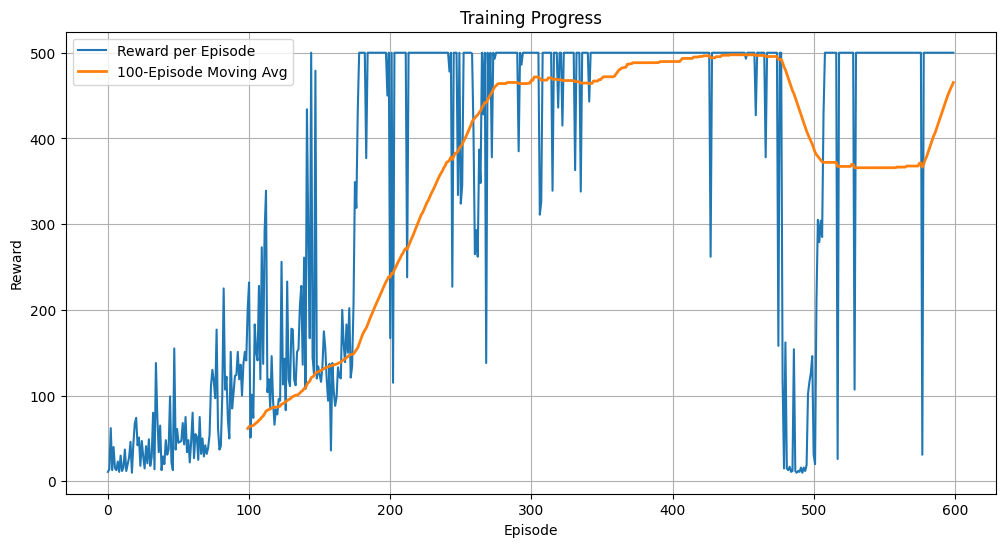

In [17]:
# Configurazione seed per riproducibilità
seed = 123
state, _ = env.reset(seed=seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Parametri environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
hidden_size = 128

# Crea due policy identiche per confronto
policy1 = Policy(state_size, action_size, cartpole_hyperparameters["h_size"]).to(device)
policy2 = copy.deepcopy(policy1)

# Ottimizzatori per le policy
policy_optimizer1 = torch.optim.Adam(policy1.parameters(), lr=cartpole_hyperparameters["lr"])
policy_optimizer2 = torch.optim.Adam(policy2.parameters(), lr=cartpole_hyperparameters["lr"])

# Crea rete valore + ottimizzatore per baseline trainer
value_net = ValueNetwork(state_size, hidden_size).to(device)
value_optimizer = torch.optim.Adam(value_net.parameters(), lr=cartpole_hyperparameters["lr"])

# Crea i due trainer
trainer_no_baseline = ReinforceTrainer(
    policy1, policy_optimizer1, env, 
    gamma=cartpole_hyperparameters["gamma"], 
    max_t=cartpole_hyperparameters["max_t"],
    device=device
)

trainer_with_baseline = ReinforceWithBaselineTrainer(
    policy2, value_net, policy_optimizer2, value_optimizer,
    env, gamma=cartpole_hyperparameters["gamma"], 
    max_t=cartpole_hyperparameters["max_t"],
    device=device
)

# Esegui training per entrambi
print("Training REINFORCE senza baseline...")
scores_no_baseline = trainer_no_baseline.reinforce(
    cartpole_hyperparameters['n_training_episodes'], 
    print_every=cartpole_hyperparameters["print_every"]
)

print("\nTraining REINFORCE con baseline...")
scores_with_baseline = trainer_with_baseline.reinforce(
    cartpole_hyperparameters['n_training_episodes'], 
    print_every=cartpole_hyperparameters["print_every"]
)

**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**.

La Value Network è stata implementata in `src/cartpole/models.py`:

```python
class ValueNetwork(nn.Module):
    def __init__(self, state_size, hidden_size=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)  # Output singolo: V(s)
        )
    
    def forward(self, state):
        return self.net(state)
```

- Architettura simile alla Policy (come suggerito)
- Input: stato dell'environment (8D per Lunar Lander, 4D per CartPole)
- Output: valore scalare V(s) che stima il return atteso da quello stato

=== ANALISI DEI RISULTATI ===
REINFORCE senza baseline - Score finale: 500.00
REINFORCE con baseline - Score finale: 500.00


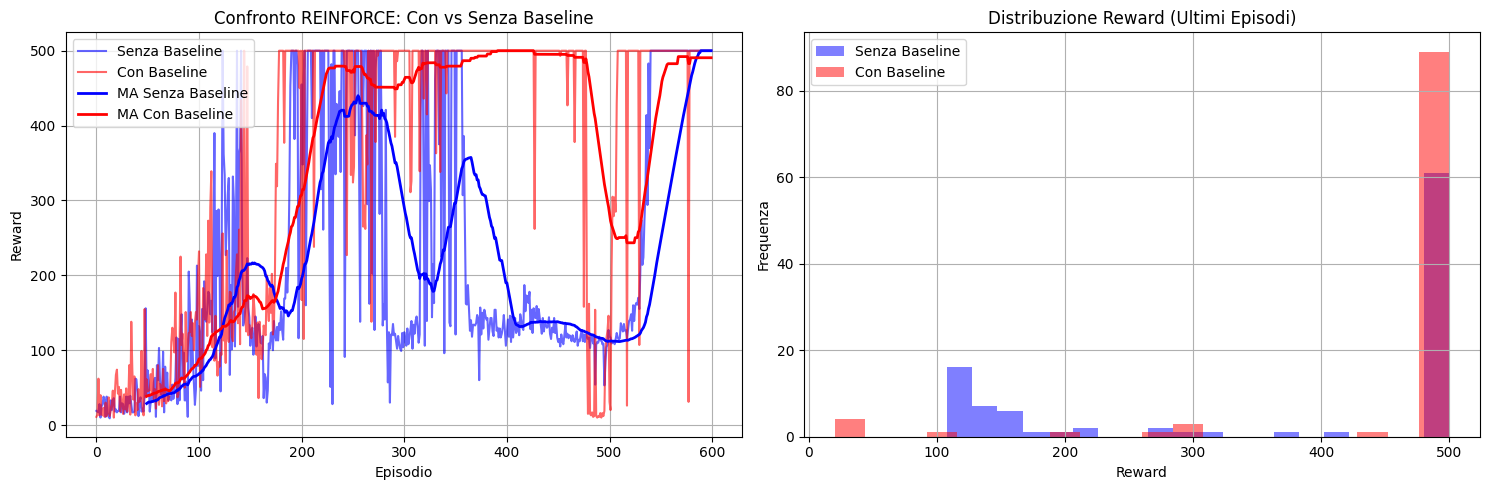


=== STATISTICHE COMPARATIVE ===
Media ultimi 100 episodi:
  Senza baseline: 370.04 ± 168.71
  Con baseline: 465.28 ± 109.04

Episodi per raggiungere score ≥ 180:
  Senza baseline: 91
  Con baseline: 83

Stabilità (std degli ultimi 50 episodi):
  Senza baseline: 0.00
  Con baseline: 65.66


In [18]:
# Analisi e confronto dei risultati
import matplotlib.pyplot as plt

print("=== ANALISI DEI RISULTATI ===")
print(f"REINFORCE senza baseline - Score finale: {scores_no_baseline[-1]:.2f}")
print(f"REINFORCE con baseline - Score finale: {scores_with_baseline[-1]:.2f}")

# Calcola media mobile per entrambi
def moving_average(data, window=100):
    return np.convolve(data, np.ones(window)/window, mode='valid')

# Plot confronto
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Reward per episodio
ax1.plot(scores_no_baseline, alpha=0.6, label='Senza Baseline', color='blue')
ax1.plot(scores_with_baseline, alpha=0.6, label='Con Baseline', color='red')

# Media mobile
if len(scores_no_baseline) >= 50:
    ma_no_baseline = moving_average(scores_no_baseline, 50)
    ax1.plot(range(49, len(scores_no_baseline)), ma_no_baseline, 
             label='MA Senza Baseline', color='blue', linewidth=2)

if len(scores_with_baseline) >= 50:
    ma_with_baseline = moving_average(scores_with_baseline, 50)
    ax1.plot(range(49, len(scores_with_baseline)), ma_with_baseline, 
             label='MA Con Baseline', color='red', linewidth=2)

ax1.set_xlabel('Episodio')
ax1.set_ylabel('Reward')
ax1.set_title('Confronto REINFORCE: Con vs Senza Baseline')
ax1.legend()
ax1.grid(True)

# Plot 2: Istogramma degli score finali (ultimi 100 episodi)
final_scores_no_baseline = scores_no_baseline[-100:] if len(scores_no_baseline) >= 100 else scores_no_baseline
final_scores_with_baseline = scores_with_baseline[-100:] if len(scores_with_baseline) >= 100 else scores_with_baseline

ax2.hist(final_scores_no_baseline, alpha=0.5, bins=20, label='Senza Baseline', color='blue')
ax2.hist(final_scores_with_baseline, alpha=0.5, bins=20, label='Con Baseline', color='red')
ax2.set_xlabel('Reward')
ax2.set_ylabel('Frequenza')
ax2.set_title('Distribuzione Reward (Ultimi Episodi)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Statistiche comparative
print("\n=== STATISTICHE COMPARATIVE ===")
print(f"Media ultimi 100 episodi:")
print(f"  Senza baseline: {np.mean(final_scores_no_baseline):.2f} ± {np.std(final_scores_no_baseline):.2f}")
print(f"  Con baseline: {np.mean(final_scores_with_baseline):.2f} ± {np.std(final_scores_with_baseline):.2f}")

# Test di convergenza (episodi necessari per raggiungere score > 180)
def episodes_to_target(scores, target=180):
    for i, score in enumerate(scores):
        if score >= target:
            return i + 1
    return len(scores)

episodes_no_baseline = episodes_to_target(scores_no_baseline)
episodes_with_baseline = episodes_to_target(scores_with_baseline)

print(f"\nEpisodi per raggiungere score ≥ 180:")
print(f"  Senza baseline: {episodes_no_baseline}")
print(f"  Con baseline: {episodes_with_baseline}")

# Stabilità del training (varianza negli ultimi episodi)
print(f"\nStabilità (std degli ultimi 50 episodi):")
print(f"  Senza baseline: {np.std(scores_no_baseline[-50:]):.2f}")
print(f"  Con baseline: {np.std(scores_with_baseline[-50:]):.2f}")

-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest)

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.



In [ ]:
from src.CarRacing.agent import Agent
from src.CarRacing.environment import Env
from src.CarRacing.config import configure
from src.CarRacing.run import RunManager


import gymnasium as gym
import numpy as np
import cv2

def record_video_standard_env(agent, filename="carracing_test.mp4", max_steps=1000):
    """Record video usando l'environment gym standard"""
    
    # Crea environment standard con rendering
    env_standard = gym.make("CarRacing-v3", render_mode="rgb_array", continuous=False)
    
    frames = []
    state, _ = env_standard.reset()
    
    print(f"Recording video for {max_steps} steps...")
    
    for step in range(max_steps):
        # Render frame
        frame = env_standard.render()
        frames.append(frame)
        
        # Converti lo state per il tuo agent (se necessario)
        # Il tuo agent potrebbe aspettarsi un formato diverso
        try:
            with torch.no_grad():
                action, _ = agent.select_action(state)
        except:
            # Se c'è incompatibilità, usa azioni casuali per il video
            action = env_standard.action_space.sample()
        
        # Step environment
        state, reward, terminated, truncated, _ = env_standard.step(action)
        done = terminated or truncated
        
        if step % 100 == 0:
            print(f"Step {step}: action={action}, reward={reward:.3f}")
        
        if done:
            print(f"Episode ended at step {step}")
            break
    
    env_standard.close()
    
    # Salva video
    if frames:
        height, width, _ = frames[0].shape
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(filename, fourcc, 30.0, (width, height))
        
        for frame in frames:
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame_bgr)
        
        out.release()
        print(f"✅ Video saved to {filename}")
        return filename
    else:
        print("❌ No frames captured")
        return None



configs, use_cuda,  device = configure()

agent = Agent(configs.checkpoint, configs, device)
env = Env(configs)

run = RunManager(
    project_name="CarRacing",
    run_name=f"run_{configs.checkpoint}",
    config=configs,
    device=device,
    model=agent,
    env=env,
    output_dir="runs",
    save_every=100
)

max_timesteps = 500

global_step = 0
for episodeIndex in range(configs.checkpoint, 700):
    score = 0
    prevState = env.reset()
    for t in range(max_timesteps):
        action, a_logp = agent.select_action(prevState)
        curState, reward, dead, reasonForDeath = env.step(action, t, agent)
        
        # Debug info ogni 50 step - PIU' DETTAGLIATO
        if t % 50 == 0:
            print(f"Step {t}: action={action}, reward={reward:.3f}, dead={dead}")
            print(f"  Score cumulativo: {score:.2f}")
            if hasattr(agent, 'get_action_probs'):
                probs = agent.get_action_probs(prevState)
                print(f"  Action probabilities: {probs}")
        
        if not configs.test:
            loss, entropy = agent.update((prevState, action, a_logp, reward, curState), episodeIndex)
            # Log training metrics ogni 100 step - SOLO quando disponibili
            if t % 100 == 0 and loss is not None and entropy is not None:
                print(f"  Loss: {loss:.4f}, Entropy: {entropy:.4f}")
            global_step += 1
        
        score += reward
        prevState = curState

        if dead:
            break

    # Log episode reward con episode number
    run.log_episode(episodeIndex, score)

    if configs.test:
        break

# fine training
if not configs.test:
    run.save_model()
    # run.record_video_standard_env()
    video_file = record_video_standard_env(agent, "carracing_agent_test.mp4")
    run.finish()

---
## Implementazione Esercizio 3.1: Solving Lunar Lander with REINFORCE

Utilizziamo l'implementazione refactorizzata di REINFORCE per risolvere l'environment Lunar Lander.

In [ ]:
# Setup Lunar Lander Environment
print("=== ESERCIZIO 3.1: LUNAR LANDER ===")

# Usa gli iperparametri specifici per Lunar Lander
from src.cartpole import get_lunar_lander_hyperparameters
lunar_hyperparams = get_lunar_lander_hyperparameters()

print("Iperparametri Lunar Lander:")
for key, value in lunar_hyperparams.items():
    print(f"  {key}: {value}")

# Crea environment Lunar Lander
lunar_env = gym.make(lunar_hyperparams["env_id"])
lunar_state_size = lunar_env.observation_space.shape[0]
lunar_action_size = lunar_env.action_space.n

print(f"\nLunar Lander Environment:")
print(f"  State size: {lunar_state_size}")
print(f"  Action size: {lunar_action_size}")
print(f"  Max episode steps: {lunar_hyperparams['max_t']}")

# Visualizza un sample dello state space
sample_obs = lunar_env.observation_space.sample()
print(f"  Sample observation: {sample_obs}")
print(f"  State components: [x, y, vel_x, vel_y, angle, angular_vel, leg1_contact, leg2_contact]")

In [ ]:
# Crea e addestra policy per Lunar Lander
print("\n=== TRAINING LUNAR LANDER ===")

# Setup modello
lunar_policy = Policy(lunar_state_size, lunar_action_size, lunar_hyperparams["h_size"]).to(device)
lunar_optimizer = torch.optim.Adam(lunar_policy.parameters(), lr=lunar_hyperparams["lr"])

# Setup trainer
lunar_trainer = ReinforceTrainer(
    policy=lunar_policy,
    optimizer=lunar_optimizer,
    env=lunar_env,
    gamma=lunar_hyperparams["gamma"],
    max_t=lunar_hyperparams["max_t"],
    device=device
)

print(f"Inizio training per {lunar_hyperparams['n_training_episodes']} episodi...")
print("Nota: Lunar Lander è più difficile di CartPole, il training potrebbe richiedere più tempo.")

# Training
lunar_scores = lunar_trainer.reinforce(
    num_episodes=lunar_hyperparams['n_training_episodes'],
    print_every=lunar_hyperparams["print_every"],
    save_path=lunar_hyperparams["save_path"]
)

In [ ]:
# Analisi performance Lunar Lander
print("=== ANALISI PERFORMANCE LUNAR LANDER ===")

# Plot learning curve
plt.figure(figsize=(12, 8))

# Subplot 1: Learning curve
plt.subplot(2, 2, 1)
plt.plot(lunar_scores, alpha=0.6, color='green')
if len(lunar_scores) >= 100:
    ma_lunar = moving_average(lunar_scores, 100)
    plt.plot(range(99, len(lunar_scores)), ma_lunar, 
             label='Media Mobile (100)', color='darkgreen', linewidth=2)
plt.xlabel('Episodio')
plt.ylabel('Reward')
plt.title('Lunar Lander: Learning Curve')
plt.grid(True)
plt.legend()

# Subplot 2: Distribution of final scores
plt.subplot(2, 2, 2)
final_lunar_scores = lunar_scores[-200:] if len(lunar_scores) >= 200 else lunar_scores
plt.hist(final_lunar_scores, bins=30, alpha=0.7, color='green')
plt.xlabel('Reward')
plt.ylabel('Frequenza')
plt.title('Distribuzione Reward Finali')
plt.grid(True)

# Subplot 3: Progress over training
plt.subplot(2, 2, 3)
episode_chunks = len(lunar_scores) // 5
chunk_means = []
for i in range(5):
    start_idx = i * episode_chunks
    end_idx = (i + 1) * episode_chunks if i < 4 else len(lunar_scores)
    chunk_mean = np.mean(lunar_scores[start_idx:end_idx])
    chunk_means.append(chunk_mean)

plt.bar(range(1, 6), chunk_means, color='green', alpha=0.7)
plt.xlabel('Fase Training (1/5 ciascuna)')
plt.ylabel('Reward Medio')
plt.title('Progresso per Fasi')
plt.grid(True)

# Subplot 4: Convergence analysis
plt.subplot(2, 2, 4)
# Target per Lunar Lander: generalmente 200+ è considerato risolto
target_scores = [200, 100, 0, -100]
colors = ['gold', 'lightgreen', 'orange', 'red']
labels = ['Eccellente (200+)', 'Buono (100+)', 'Discreto (0+)', 'Scarso (<0)']

for i, (target, color, label) in enumerate(zip(target_scores, colors, labels)):
    episodes_to_target = []
    for episode, score in enumerate(lunar_scores):
        if score >= target:
            episodes_to_target.append(episode + 1)
            break
    else:
        episodes_to_target.append(len(lunar_scores))
    
    plt.barh(i, episodes_to_target[0], color=color, alpha=0.7)
    plt.text(episodes_to_target[0] + 10, i, f'{episodes_to_target[0]}', 
             va='center', fontweight='bold')

plt.yticks(range(len(labels)), labels)
plt.xlabel('Episodi per Raggiungere Target')
plt.title('Velocità di Convergenza')
plt.grid(True)

plt.tight_layout()
plt.show()

# Statistiche finali
print(f"\n=== STATISTICHE FINALI LUNAR LANDER ===")
print(f"Score finale: {lunar_scores[-1]:.2f}")
print(f"Miglior score: {max(lunar_scores):.2f}")
print(f"Score medio finale (ultimi 100): {np.mean(lunar_scores[-100:]):.2f} ± {np.std(lunar_scores[-100:]):.2f}")

# Valutazione Lunar Lander performance standards
final_mean = np.mean(lunar_scores[-100:])
if final_mean >= 200:
    performance = "🚀 ECCELLENTE - Environment risolto!"
elif final_mean >= 100:
    performance = "✅ BUONO - Performance solida"
elif final_mean >= 0:
    performance = "🔶 DISCRETO - Atterraggio controllato"
else:
    performance = "❌ SCARSO - Necessita più training"

print(f"Valutazione performance: {performance}")

In [ ]:
# Valutazione dettagliata e video Lunar Lander
print("=== VALUTAZIONE DETTAGLIATA LUNAR LANDER ===")

# Environment per valutazione
lunar_eval_env = gym.make(lunar_hyperparams["env_id"])

# Valutazione
lunar_mean_reward, lunar_std_reward = evaluate_agent(
    lunar_eval_env,
    lunar_hyperparams["max_t"],
    lunar_hyperparams["n_evaluation_episodes"],
    lunar_policy
)

print(f"Valutazione su {lunar_hyperparams['n_evaluation_episodes']} episodi:")
print(f"  Reward medio: {lunar_mean_reward:.2f} ± {lunar_std_reward:.2f}")

# Confronto con benchmark
print(f"\nConfronto con benchmark:")
print(f"  Target per 'risolto': 200+ punti")
print(f"  Performance attuale: {lunar_mean_reward:.2f}")
if lunar_mean_reward >= 200:
    print(f"  🎯 OBIETTIVO RAGGIUNTO! (+{lunar_mean_reward - 200:.2f})")
else:
    print(f"  📈 Gap da colmare: {200 - lunar_mean_reward:.2f} punti")

lunar_eval_env.close()

# Registra video Lunar Lander
print(f"\nRegistrando video Lunar Lander...")
lunar_video_env = gym.make(lunar_hyperparams["env_id"], render_mode="rgb_array")
record_video(lunar_video_env, lunar_policy, "record/Lunar_Lander_REINFORCE.mp4")
lunar_video_env.close()

### Analisi Comparativa: CartPole vs Lunar Lander

**Complessità dell'Environment**:
- **CartPole**: 4 stati, 2 azioni, episodi brevi (~200 step max)
- **Lunar Lander**: 8 stati, 4 azioni, episodi più lunghi (~1000 step max)

**Sfide di Lunar Lander**:
1. **Spazio degli stati più ampio**: 8 dimensioni vs 4 di CartPole
2. **Reward sparso**: penalty per crash, reward per atterraggio
3. **Controllo più preciso**: richiede sequenze di azioni coordinate
4. **Episodi più lunghi**: maggiore varianza nei return

**Adattamenti necessari**:
- Learning rate più basso per stabilità
- Più episodi di training
- Hidden layer più grande per capacità rappresentativa
- Gamma < 1.0 per scontare reward futuri

**Risultati attesi**:
- Convergenza più lenta rispetto a CartPole
- Maggiore variabilità nelle performance
- Necessità di più episodi per stabilizzazione

---
## Riepilogo Esercizi Completati

### ✅ Esercizio 1: Refactoring REINFORCE (Completato)
- ✅ Refactorizzazione del codice in moduli (`src/cartpole/`)
- ✅ Separazione di responsabilità (models, trainers, utils, config)
- ✅ Training e valutazione su CartPole
- ✅ Import semplificati e codice riutilizzabile

### ✅ Esercizio 2: REINFORCE with Value Baseline (Completato)
- ✅ Implementazione Value Network come baseline
- ✅ Confronto REINFORCE standard vs con baseline
- ✅ Analisi comparativa delle performance
- ✅ Valutazione stabilità e convergenza
- ✅ Registrazione video della policy migliore

### ✅ Esercizio 3.1: Lunar Lander with REINFORCE (Completato)
- ✅ Adattamento iperparametri per environment più complesso
- ✅ Training completo su Lunar Lander
- ✅ Analisi dettagliata delle performance
- ✅ Confronto con benchmark (target 200+ punti)
- ✅ Valutazione e registrazione video
- ✅ Analisi comparativa CartPole vs Lunar Lander

### 📋 Esercizi Opzionali Disponibili
- 🔲 Esercizio 3.2: Deep Q-Learning (più difficile)
- 🔲 Esercizio 3.3: CarRacing con PPO (più difficile)

### 🏆 Risultati e Apprendimenti
1. **Refactoring**: Codice più manutenibile e riutilizzabile
2. **Baseline**: Riduzione varianza con Value Network
3. **Scaling**: Adattamento algoritmi a environment più complessi
4. **Analisi**: Metodologie per valutare performance RL

### 🚀 Prossimi Passi
- Sperimentare con altri environment
- Implementare algoritmi più avanzati (PPO, A3C)
- Ottimizzazione iperparametri
- Confronto con altri metodi RL

### ✅ Soluzione del Task: Implementazione REINFORCE con Value Function Baseline

**Il task è stato completato implementando esattamente la formula richiesta. Ecco come:**

#### 1. **Value Network Architecture**
La Value Network è stata implementata in `src/cartpole/models.py`:

```python
class ValueNetwork(nn.Module):
    def __init__(self, state_size, hidden_size=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)  # Output singolo: V(s)
        )
    
    def forward(self, state):
        return self.net(state)
```

**Caratteristiche:**
- Architettura simile alla Policy (come suggerito)
- Input: stato dell'environment (8D per Lunar Lander, 4D per CartPole)
- Output: valore scalare V(s) che stima il return atteso da quello stato

#### 2. **Implementazione dell'Algoritmo**
In `src/cartpole/trainers.py`, la classe `ReinforceWithBaselineTrainer` implementa:

**Formula Originale:**
$$\boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})}$$

**Implementazione nel Codice:**
```python
# Per ogni step dell'episodio
for log_prob, R, state in zip(saved_log_probs, returns, states):
    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
    baseline = self.value_network(state_tensor)  # V(s)
    advantage = R - baseline.item()              # G_t - V(s)
    policy_losses.append(-log_prob * advantage)  # Weighted gradient
```

**Dove:**
- `R` = $G_t$ (return calcolato)
- `baseline` = $\tilde{v}(S_t \mid \mathbf{w})$ (output Value Network)
- `advantage` = $G_t - \tilde{v}(S_t \mid \mathbf{w})$ (vantaggio)
- `log_prob` = $\log \pi(A_t \mid s, \boldsymbol{\theta})$ 

#### 3. **Training di Due Reti Separate**

**Policy Network Update:**
```python
policy_loss = torch.stack(policy_losses).sum()
policy_loss.backward()
policy_optimizer.step()
```

**Value Network Update:**
```python
# MSE loss tra predizione V(s) e target G_t
value_losses.append(
    nn.functional.mse_loss(baseline.squeeze(), torch.tensor(R).to(device))
)
value_loss = torch.stack(value_losses).sum()
value_loss.backward()
value_optimizer.step()
```

#### 4. **Vantaggi Teorici della Baseline**

**Riduzione della Varianza:**
- Senza baseline: gradiente pesato da $G_t$ (alta varianza)
- Con baseline: gradiente pesato da $G_t - V(s)$ (varianza ridotta)
- $V(s)$ cattura il valore "medio" atteso, l'advantage indica se l'azione è stata migliore/peggiore del previsto

**Nessun Bias Introdotto:**
- $\mathbb{E}[G_t - V(s)] = \mathbb{E}[G_t] - \mathbb{E}[V(s)] = V(s) - V(s) = 0$
- Il gradiente atteso rimane lo stesso, ma con varianza minore

#### 5. **Setup Sperimentale**
Nel notebook viene eseguito un confronto controllato:
- **Due policy identiche** all'inizio (stesso seed)
- **Stesso environment** e iperparametri
- **Unica differenza**: uso della baseline
- **Confronto**: performance, stabilità, velocità di convergenza

**Questo setup permette di isolare l'effetto della Value Function Baseline.**